In [1]:
from input_table import create_inputs
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import truncnorm

# Generate n values from a truncated normal distribution with mean mu and standard deviation sigma,
# and truncated to the range [min_value, max_value].
def truncated_normal(mu, sigma, min_value, max_value, n):
    assert min_value < max_value and sigma > 0 and n > 0
    a, b = (min_value - mu) / sigma, (max_value - mu) / sigma
    samples = [int (x) for x in truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n)]
    return samples

class Load:
    # For now, sinusoidal time-varying server load model with peak in the afternoon.
    # Load between 0 and 1, in 2-hour intervals starting at 0:00-1:59.
    load_by_hours = [
        0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 0.8, 0.6, 0.6
    ]

    @staticmethod
    def at_hour(hour):
        assert 0 <= hour < 24
        return max(0, min(Load.load_by_hours[hour // 2] + random.uniform(-0.1, 0.1), 1))

class Emissions:
    # Average direct (not including LCA) emissions factors in g CO2e per kWh
    # for electricity consumed for each pair of hours starting
    # with 0:00-1:59, based on hourly data for 2023 from https://electricitymaps.com/.
    gco2_per_kwh_by_hours = {
        'ch': [ 63, 58, 58, 52, 49, 47, 45, 45, 49, 54, 62, 63 ],
    }

    @staticmethod
    def at_hour(hour, country):
        return Emissions.gco2_per_kwh_by_hours[country][hour // 2]

    @staticmethod
    def average(country):
        return sum(Emissions.gco2_per_kwh_by_hours[country]) / len(Emissions.gco2_per_kwh_by_hours[country])


In [2]:
people = {
    'uzh population': {
        'students': 28000,
        'staff': 10000,
    },
}

devices = {
    'laptops': { 
        'lifetime': 4,
        'count': 38000,
    },
    'desktops': { 
        'lifetime': 6,
        'count': 150,
    },
    'servers': { 
        'lifetime': 5,
        'count': 1028,
    },
    'smartphones': { 
        'lifetime': 3,
        'count': 38000,
    },
    'wall displays': { # Includes projectors
        'lifetime': 6,
        'count': 360,
    },
    'monitors': { 
        'lifetime': 6,
        'count': 10175+150,
    },
    'printers': { 
        'lifetime': 6,
        'count': 1000,
    },
}

embodied_emissions_kg_co2e = {
    'laptops': {
        'average': 244,     # https://github.com/rarecoil/laptop-co2e
        'stdev': 128,       # https://github.com/rarecoil/laptop-co2e
        'lower_bound': 104, # Mean - 1 stdev
        'upper_bound': 372, # Teehan and Kandlikar 2013
    },
    'desktops': {
        'average': 289,     # Dell data
        'stdev': 80,        # Dell data
        'lower_bound': 209, # Mean - 1 stdev
        'upper_bound': 403, # UN Digital Economy report 2024
    },
    'servers': {
        'average': 1252,    # Dell data
        'stdev': 330,       # Dell data
        'lower_bound': 383, # Teehan and Kandlikar 2013
        'upper_bound': 1582,# Mean + 1 stdev
    },
    'smartphones': {
        'average': 50,      # UN Digital Economy report 2024
        'stdev': 10,
        'lower_bound': 30,
        'upper_bound': 70,  # Pixel 8
    },
    'monitors': {
        'average': 344,     # Teehan and Kandlikar 2013
        'stdev': 50,        # Guess
        'lower_bound': 294, # Mean - 1 stdev
        'upper_bound': 394, # Mean + 1 stdev
    },
    'wall displays': {
        'average': 753,     # Scaled from monitors
        'stdev': 109,       # Scaled from monitors
        'lower_bound': 644, # Mean - 1 stdev
        'upper_bound': 862 ,# Mean + 1 stdev
    },
    'printers': {
        'average': 1167,    # Ecoinvent
        'stdev': 200,       # Guess
        'lower_bound': 967, # Mean - 1 stdev
        'upper_bound': 1367,# Mean + 1 stdev
    },
}

power_w = {
    # Assumptions based on some manufacturer data sheets.
    'laptops': {
        'average': 30,
        'stdev': 5,
        'lower_bound': 20,
        'upper_bound': 40,
        'standby': 1,
    },
    'desktops': {
        'average': 100,      
        'stdev': 20,         
        'lower_bound': 60,
        'upper_bound': 200,
        'standby': 1,
    },
    'servers': {
        'average': 400,
        'stdev': 100,
        'lower_bound': 200,
        'upper_bound': 600,
        'standby': 1,
    },
    'smartphones': {
        'average': 5,
        'stdev': 2,
        'lower_bound': 3,
        'upper_bound': 7,
        'standby': 0,
    },
    'monitors': {
        'average': 50,
        'stdev': 10,
        'lower_bound': 30,
        'upper_bound': 90,
        'standby': 1,
    },
    'wall displays': {
        'average': 250,
        'stdev': 50,
        'lower_bound': 150,
        'upper_bound': 350,
        'standby': 1,
    },
    'printers': {
        'average': 1000,
        'stdev': 200,
        'lower_bound': 600,
        'upper_bound': 1400,
        'standby': 90,
    },
}

duty_cycle_6h = {
    # Fraction of time active during 0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59.
    'laptops': [0.1, 0.5, 1.0, 0.3],
    'desktops': [0.1, 0.5, 1.0, 0.3],
    'servers': [0.8, 0.8, 0.8, 0.8],
    'smartphones': [0.0, 0.0, 0.0, 0.5], # Evening recharge
    'monitors': [0.1, 0.5, 1.0, 0.3],
    'wall displays': [0.0, 0.3, 0.6, 0.1],
    'printers': [0.0, 0.0, 0.01, 0.0], # Five minutes per day of active printing
}

cloud_server_data = {
    'cloud_server': {
        'instances_per_local_server': 1,
        'annual_manufacturing_kg_co2e': 97,
        'annual_usage_kg_co2e': 31,
    }
}

llm_usage = {
    'LLM daily user queries': {
        'average': 15,
        'stdev': 5,
        'lower_bound': 0,
        'upper_bound': 30,
    },
}

llm_power = {
    'LLM power': {
        'average query wh': 3.5,
        'emissions intensity': 226, # g CO2e per kWh (EU average) https://www.climate-transparency.org/wp-content/uploads/2022/10/CT2022-EU-Web.pdf
    },
}

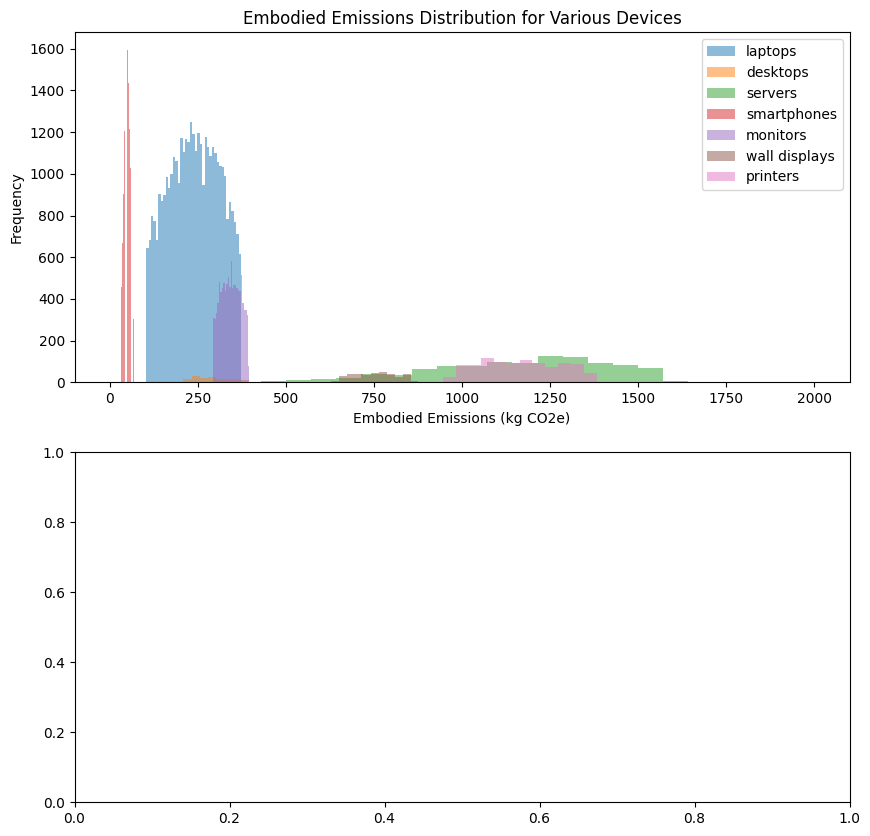

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

for device, stats in embodied_emissions_kg_co2e.items():
    mu = stats['average']
    sigma = stats['stdev']
    min_value = stats['lower_bound']
    max_value = stats['upper_bound']
    n = devices[device]['count']
    samples = truncated_normal(mu, sigma, min_value, max_value, n)
    ax1.hist(samples, bins='auto', alpha=0.5, label=device, range=(0, 2000))

ax1.set_xlabel('Embodied Emissions (kg CO2e)')
ax1.set_ylabel('Frequency')
ax1.set_title('Embodied Emissions Distribution for Various Devices')
ax1.legend()
plt.draw()

for device, stats in power_w.items():
    mu = stats['average']
    sigma = stats['stdev']
    min_value = stats['lower_bound']
    max_value = stats['upper_bound']
    n = devices[device]['count']
    samples = truncated_normal(mu, sigma, min_value, max_value, n)
    ax2.hist(samples, bins='auto', alpha=0.5, label=device, range=(0, 1500))

ax2.set_xlabel('Power Consumption (W)')
ax2.set_ylabel('Frequency')
ax2.set_title('Power Consumption Distribution for Various Devices')
ax2.legend()
ax2.set_yscale('log')
plt.tight_layout()
plt.show()
